In [1]:
import numpy as np
from scipy import signal
from matplotlib import pyplot as plt
import cv2
import maxflow
import networkx as nx

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
img_org = cv2.imread("imgs/a.png",cv2.IMREAD_GRAYSCALE).astype(np.float)
img = cv2.imread("imgs/a2.png",cv2.IMREAD_GRAYSCALE).astype(np.float)

In [3]:
# binary image restoration
# http://pmneila.github.io/PyMaxflow/tutorial.html#tutorial
# other python wrappers
# http://cmp.felk.cvut.cz/~smidm/python-packages-for-graph-cuts-on-images.html

# graph setup
# create the graph with int capacities
g = maxflow.Graph[int]()
# add nodes. nodeids has the identifiers of the nodes in the grid.
nodeids = g.add_grid_nodes(img.shape)
# add non-terminal edges with the same capacity.
g.add_grid_edges(nodeids, 50)
# add the terminal edges. The image pixels are the capacities
# of the edges from the source node. The inverted image pixels
# are the capacities of the edges to the sink node.
g.add_grid_tedges(nodeids, img, 255-img)

# find the maximum flow.
g.maxflow()
# get the segments of the nodes in the grid.
sgm = g.get_grid_segments(nodeids)
# the labels should be 1 where sgm is False and 0 otherwise.
img_bin = np.int_(np.logical_not(sgm))

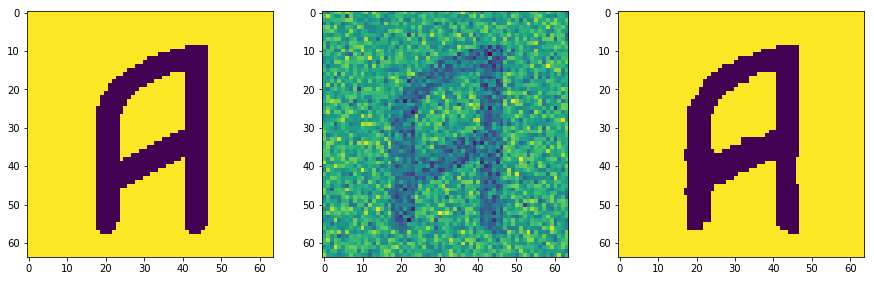

In [4]:
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.imshow(img_org)
plt.subplot(132)
plt.imshow(img)
plt.subplot(133)
plt.imshow(img_bin)

In [5]:
# generic graph manipulation
# https://github.com/pmneila/PyMaxflow/issues/22
g = maxflow.Graph[int]()

# add nodes
nodes = g.add_nodes(20)

# add edges
# connect i to the rest
i = nodes[0]
rest = nodes[1:]
num_connections = len(rest)

# Some arbitrary weights
weights = np.arange(num_connections) + 1

# Create an auxiliary layout of the nodes just for setting the edges
# [[i, i, i, i,...],
#  [j, k, l, m,...]]
nodeids = np.array([[i] * num_connections, rest])

# Create edges in the down direction with given weights
structure = np.zeros((3, 3))
structure[2, 1] = 1
g.add_grid_edges(nodeids, weights, structure)

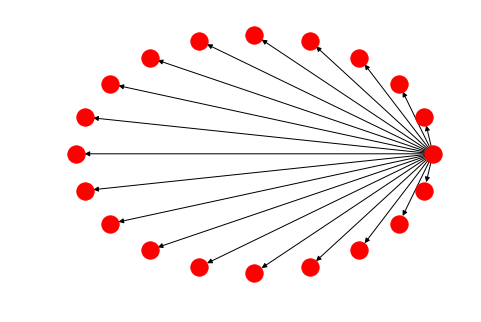

In [6]:
# Plot the graph
nxg = g.get_nx_graph()
nxg.remove_nodes_from(['s', 't'])
nx.draw_circular(nxg)

255.0
255.0
255.0


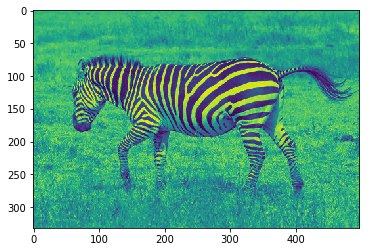

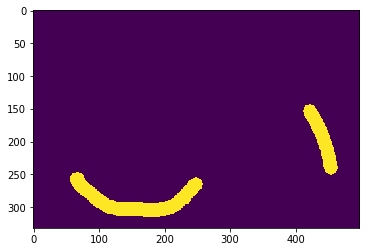

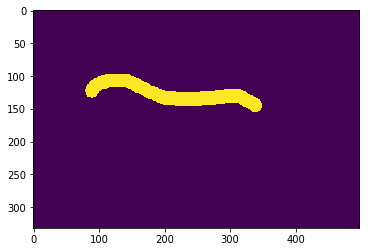

In [7]:
# image segmentation
img = cv2.imread("imgs/zebra.jpg",cv2.IMREAD_GRAYSCALE).astype(np.float)
mask = cv2.imread("imgs/zebra_brush.png",cv2.IMREAD_COLOR).astype(np.float)

plt.figure()
plt.imshow(img)
print(np.max(img))
plt.figure()
plt.imshow(mask[:,:,0])
print(np.max(mask[:,:,0]))
plt.figure()
plt.imshow(mask[:,:,2])
print(np.max(mask[:,:,2]))

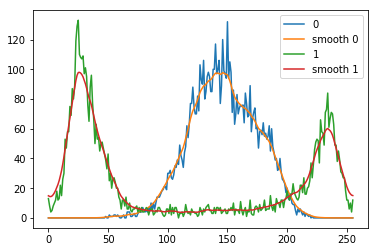

In [8]:
# image segmentation using histogram
# https://cw.fel.cvut.cz/old/courses/b4m33dzo/labs/4_segmentation
pixs = [img[mask[:,:,0] == 255.],img[mask[:,:,2] == 255.]]

# find histogram
hists = [np.histogram(pixs[k],256,(0,255))[0] for k in range(2)]
# smooth histogram, does not have to be causal
# https://dsp.stackexchange.com/questions/19084/applying-filter-in-scipy-signal-use-lfilter-or-filtfilt
hists_smooth = [signal.filtfilt(0.2,[1,-0.8],hists[k]) for k in range(2)]
plt.figure()
for k in range(2):
    plt.plot(hists[k],label='%s' % k)
    plt.plot(hists_smooth[k],label='smooth %s' % k)
plt.legend()

# normalize to obtain pmf term
pmfs_smooth = [hists_smooth[k]/np.sum(hists_smooth[k]) for k in range(2)]

# bayesian inference for datacost
posterior = pmfs_smooth[0]/(pmfs_smooth[0]+pmfs_smooth[1])
datacost = 255*posterior[img.astype(np.int)]

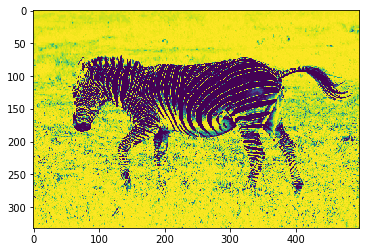

In [9]:
plt.figure()
plt.imshow(datacost)

In [10]:
# compute image gradient
sobelx = cv2.Sobel(img,cv2.CV_64F,1,0) # Find x and y gradients
sobely = cv2.Sobel(img,cv2.CV_64F,0,1)

0.0
939.0
0.0
893.0


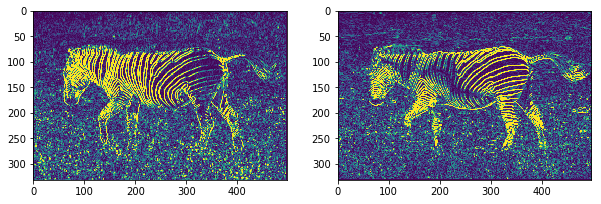

In [11]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(np.minimum(255,np.abs(sobelx)))
plt.subplot(122)
plt.imshow(np.minimum(255,np.abs(sobely)))

print(np.min(np.abs(sobelx)))
print(np.max(np.abs(sobelx)))
print(np.min(np.abs(sobely)))
print(np.max(np.abs(sobely)))

In [12]:
# image segmentation using graph cut
g = maxflow.Graph[float]()

nodeids = g.add_grid_nodes(img.shape)

g.add_grid_tedges(nodeids,datacost,255-datacost)

# non-terminal edges
# https://github.com/pmneila/PyMaxflow/issues/22
# y axis
structure = np.array([[0, 0, 0],
                      [0, 0, 0],
                      [0, 1, 0]])
weights = 2e+1*(255-np.minimum(255,np.abs(sobely)))
g.add_grid_edges(nodeids,weights,structure,symmetric=True)
# x axis
structure = np.array([[0, 0, 0],
                      [0, 0, 1],
                      [0, 0, 0]])
weights = 2e+1*(255-np.minimum(255,np.abs(sobelx)))
g.add_grid_edges(nodeids,weights,structure,symmetric=True)


# find the maximum flow.
g.maxflow()
sgm = g.get_grid_segments(nodeids)
img_bin = np.float_(np.logical_not(sgm))

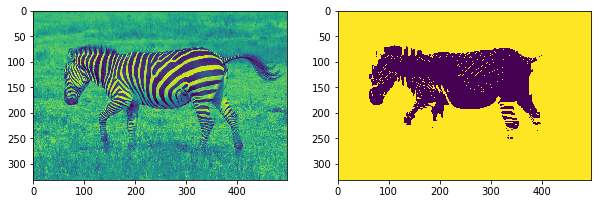

In [13]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(img_bin)